In [1]:
%pip install tensordict -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import pandas as pd
import numpy as np
import math

import textwrap

from typing import Optional
from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login

import matplotlib.pyplot as plt
from PIL import Image
from tensordict import TensorDict
from collections import defaultdict

notebook_login()

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    "Manojb/stable-diffusion-2-1-base", # "CompVis/stable-diffusion-v1-4",
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [ ]:
def collect_residual_streams(
    pipe: StableDiffusionPipeline,
    forget_set: list[str],
    retain_set: list[str],
    steps: int = 30,
    guidance: float = 7.5,
    from_timestamp: int = 25
):
    
    forget_acts = []
    retain_acts = []

    for idx, (forget_prompt, retain_prompt) in enumerate(zip(forget_set, retain_set)):
        print(f'[{idx+1}] Extracting acts for forget prompt: {forget_prompt}')
        forget_act = get_unet_residual_stream(pipe, forget_prompt, steps, guidance, from_timestamp)

        print(f'[{idx+1}] Extracting acts for retain prompt: {retain_prompt}')
        retain_act = get_unet_residual_stream(pipe, retain_prompt, steps, guidance, from_timestamp)
        
        forget_acts.append(forget_act)
        retain_acts.append(retain_act)

    return forget_acts, retain_acts


def get_unet_residual_stream(
    pipe: StableDiffusionPipeline,
    prompt: str,
    steps: int = 30,
    guidance: float = 7.5,
    from_timestamp: int = 25
):
    # designed to be, using batches would cause coherence issues when collecting acts.    

    assert 0 < from_timestamp < steps
    
    residuals_dict = {}
    handles = []

    step_counters = {}

    def save_residuals(name):
        def hook(module, input, output):
            if name not in step_counters:
                step_counters[name] = 0     

            if step_counters[name] >= from_timestamp:           
                # UNet calculates noise prediction for both conditioned and unconditioned input, so we take the second
                residual = output[1] if isinstance(output, tuple) else output
                residuals_dict.setdefault(name, []).append(residual[1].detach().cpu())

            step_counters[name] += 1
        return hook

    for i, block in enumerate(pipe.unet.down_blocks):
        for j, resnet in enumerate(block.resnets):
            handles.append(resnet.register_forward_hook(save_residuals(f"down_block_{i}_resnet_{j}")))

    for j, resnet in enumerate(pipe.unet.mid_block.resnets):
        handles.append(resnet.register_forward_hook(save_residuals(f"mid_block_resnet_{j}")))

    for i, block in enumerate(pipe.unet.up_blocks):
        for j, resnet in enumerate(block.resnets):
            handles.append(resnet.register_forward_hook(save_residuals(f"up_block_{i}_resnet_{j}")))

    pipe(
        prompt,
        num_inference_steps=steps,
        guidance_scale=guidance
    )

    for h in handles:
        h.remove()

    residuals_by_timestep = {
        layer: torch.stack(tensors, dim=0)
        for layer, tensors in residuals_dict.items()
    }

    return residuals_by_timestep # [T, C, H, W]

def show_images(images: list[Image.Image], prompts: list[str], cols: int = 2, width: int = 40) -> None:
    assert len(images) == len(prompts)

    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax in axes[len(images):]:
        ax.axis('off')

    for ax, img, prompt in zip(axes, images, prompts):
        ax.imshow(img)
        ax.axis('off')
        wrapped_prompt = "\n".join(textwrap.wrap(prompt, width=width))
        ax.text(0.5, -0.05, wrapped_prompt, fontsize=10, ha='center', va='top', transform=ax.transAxes)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()


def get_layers_activations_at_timestep(forget_acts, retain_acts, layers: list[str], ts_idx: int):
    result = {}

    forget_layers = {}
    retain_layers = {}
    
    for l in layers:
        forget_layers[l] = torch.stack([f[l][ts_idx] for f in forget_acts], dim=0)
        retain_layers[l] = torch.stack([r[l][ts_idx] for r in retain_acts], dim=0)
        
    return forget_layers, retain_layers

In [6]:
dogs_dataset = pd.read_csv('./dogs.csv')

dog_prompts = dogs_dataset['positive'].tolist()
non_dog_prompts = dogs_dataset['negative'].tolist()

**Generate a bunch of images just to visualize them**

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

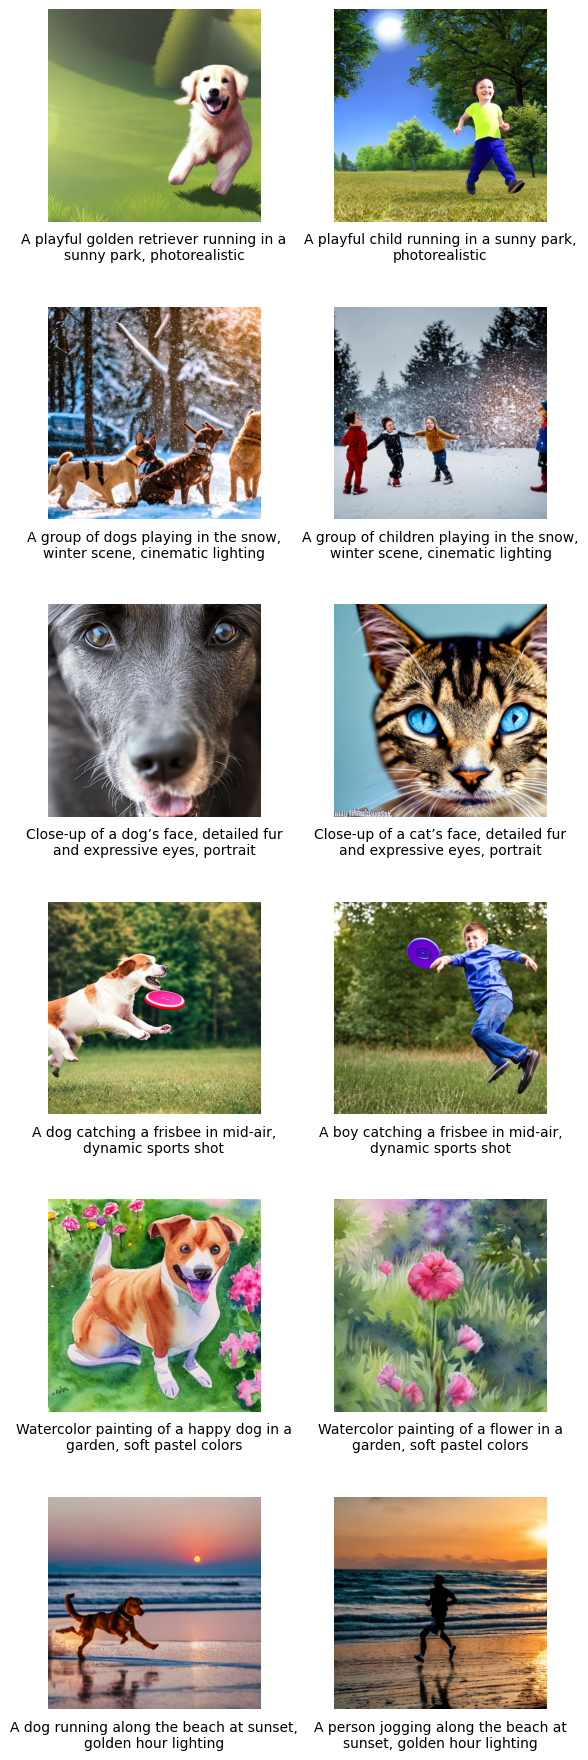

In [7]:
batch_size = 2
images_no = 6 # len(dog_prompts)

all_images = []
all_prompts = []

for i in range(0, images_no, batch_size):
    pos_batch = dog_prompts[i:i+batch_size]
    neg_batch = non_dog_prompts[i:i+batch_size]

    pos_images = pipe(pos_batch, num_inference_steps=30, guidance_scale=8).images
    neg_images = pipe(neg_batch, num_inference_steps=30, guidance_scale=8).images

    for p_img, n_img, p_prompt, n_prompt in zip(pos_images, neg_images, pos_batch, neg_batch):
        all_images.append(p_img)
        all_images.append(n_img)
        all_prompts.append(p_prompt)
        all_prompts.append(n_prompt)

show_images(all_images, all_prompts, cols=2)

**Extract raw activations and print layer names**

In [8]:
#print(pipe.unet)
forget_acts, retain_acts = collect_residual_streams(pipe, dog_prompts[:5], non_dog_prompts[:5], 30, 10, 29)

layer_names = set(forget_acts[0].keys()) # take first prompt, same layer names...

layer_names

[1] Extracting acts for forget prompt: A playful golden retriever running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[1] Extracting acts for retain prompt: A playful child running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for forget prompt: A group of dogs playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for retain prompt: A group of children playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for forget prompt: Close-up of a dog’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for retain prompt: Close-up of a cat’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for forget prompt: A dog catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for retain prompt: A boy catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for forget prompt: Watercolor painting of a happy dog in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for retain prompt: Watercolor painting of a flower in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

{'down_block_0_resnet_0',
 'down_block_0_resnet_1',
 'down_block_1_resnet_0',
 'down_block_1_resnet_1',
 'down_block_2_resnet_0',
 'down_block_2_resnet_1',
 'down_block_3_resnet_0',
 'down_block_3_resnet_1',
 'mid_block_resnet_0',
 'mid_block_resnet_1',
 'up_block_0_resnet_0',
 'up_block_0_resnet_1',
 'up_block_0_resnet_2',
 'up_block_1_resnet_0',
 'up_block_1_resnet_1',
 'up_block_1_resnet_2',
 'up_block_2_resnet_0',
 'up_block_2_resnet_1',
 'up_block_2_resnet_2',
 'up_block_3_resnet_0',
 'up_block_3_resnet_1',
 'up_block_3_resnet_2'}

**Daniele insert your code here -> Layer Navigator**
Layer navigator should return a subset of the layers just printed, possibly a dict with scores for report/debug purposes

example: layer_navigator(...) -> ['down_block_2_resnet_1', 'mid_block_resnet_0', 'mid_block_resnet_1', 'up_block_2_resnet_2']

In [ ]:
def compute_steering_vector(retain_acts, forget_acts):
    refusal_vec = (forget_acts - retain_acts).mean(dim=0)
    return refusal_vec # (D)


def process_resnet_acts(acts_list, last_t=1):
    layer_names = list(acts_list[0].keys())
    aggregated_layers = defaultdict(list)
    
    for sample in acts_list:
        for layer, activation in sample.items():
            aggregated_layers[layer].append(activation)
    temp_dict = {}

    for layer_name, batch_list in aggregated_layers.items():
        # batch_list is a list of Tensor(steps, C, H, W) for each item in the batch

        stack = torch.stack(batch_list, dim=0).to('cuda') # (N, Steps, C, H, W)
        last_steps = stack[:,-last_t:,:,:,:] # take last_t steps

        time_averaged = last_steps.mean(dim=0) # (N, C, H, W)
        #flattened = time_averaged.flatten(start_dim=1)
        spatial_averaged = time_averaged.mean(dim=(2,3))
        temp_dict[layer_name] = spatial_averaged.float() # flattened.float()

    processed_layers = TensorDict(
        temp_dict, 
        batch_size=[spatial_averaged.shape[0]], # [flattened.shape[0]], 
        device='cuda'
    )
    return processed_layers


def compute_scores(retain_acts, forget_acts):
    results = {}

    for layer in layer_names:
        P = retain_acts[layer]  # Positive (N, D)
        N = forget_acts[layer]  # Negative (N, D)

        if P.shape != N.shape:
            print(f'P shape and N shape differs in {layer}')

        n_samples = P.shape[0]

        all_acts = torch.cat([P, N], dim=0) # (2N, D)
        mu_l = all_acts.mean(dim=0, keepdim=True)  # (1, D)
        sigma_l = all_acts.std(dim=0, keepdim=True) + 1e-8 # (1, D)

        P_tilde = (P - mu_l) / sigma_l
        N_tilde = (N - mu_l) / sigma_l
        
        v_l = compute_steering_vector(P, N) # (D)

        
        # Calculate means of normalized data
        mu_pos = P_tilde.mean(dim=0) # (D)
        mu_neg = N_tilde.mean(dim=0) # (D)

        # Instead of creating (D, D) matrix, project means onto v_l
        proj_pos = torch.dot(mu_pos, v_l)
        proj_neg = torch.dot(mu_neg, v_l)
        
        # v^T Sb v = N * (proj_pos^2 + proj_neg^2)
        sb_val = n_samples * (proj_pos**2 + proj_neg**2)

        # Center the data class-wise
        P_centered = P_tilde - mu_pos.unsqueeze(0) # (N, D)
        N_centered = N_tilde - mu_neg.unsqueeze(0) # (N, D)

        # Instead of creating (D, D) covariance, project data onto v_l
        # This calculates the variance of the data along the direction of v_l
        p_proj = torch.mv(P_centered, v_l) # (N)
        n_proj = torch.mv(N_centered, v_l) # (N)

        sw_pos_val = torch.sum(p_proj**2)
        sw_neg_val = torch.sum(n_proj**2)
        sw_val = sw_pos_val + sw_neg_val

        
        D_l = (sb_val / (sb_val + sw_val + 1e-8)).item()

        pair_diffs = N_tilde - P_tilde # (N, D)
        dot_products = torch.mv(pair_diffs, v_l) # (N)
        pair_norms = torch.norm(pair_diffs, dim=1) # (N,)
        v_norm = torch.norm(v_l)
        
        cosine_sims = dot_products / (pair_norms * v_norm + 1e-8)
        C_l = cosine_sims.mean().item()

        S_l = D_l + C_l

        results[layer] = {
            "score": S_l,
            "discriminability": D_l,
            "consistency": C_l
        }
        
        del P_tilde, N_tilde, all_acts, P_centered, N_centered
        torch.cuda.empty_cache()

    return results

def get_top_k_layers(results, k=5):
    sorted_layers = sorted(results.items(), key=lambda x: x[1]['score'], reverse=True)
    return [x[0] for x in sorted_layers[:k]]

def print_report(results, top_n=5):
    print(f"\n{'Layer Name':<40} | {'Score':<8} | {'Discrim':<8} | {'Consist':<8}")
    print("-" * 75)
    sorted_layers = sorted(results.items(), key=lambda x: x[1]['score'], reverse=True)
    for layer, stats in sorted_layers[:top_n]:
        print(f"{layer:<40} | {stats['score']:.4f}   | {stats['discriminability']:.4f}   | {stats['consistency']:.4f}")

In [10]:
processed_retain = process_resnet_acts(retain_acts, last_t=1)
processed_forget = process_resnet_acts(forget_acts, last_t=1)

results = compute_scores(processed_retain, processed_forget)

top_k = get_top_k_layers(results, k=3)
print_report(results, top_n=20)


Layer Name                               | Score    | Discrim  | Consist 
---------------------------------------------------------------------------
down_block_2_resnet_1                    | 1.8498   | 0.9992   | 0.8506
up_block_1_resnet_1                      | 1.8480   | 0.9985   | 0.8495
up_block_1_resnet_2                      | 1.8479   | 0.9981   | 0.8498
up_block_1_resnet_0                      | 1.8466   | 0.9989   | 0.8478
up_block_2_resnet_1                      | 1.8392   | 0.9967   | 0.8425
up_block_2_resnet_0                      | 1.8375   | 0.9949   | 0.8426
up_block_2_resnet_2                      | 1.8362   | 0.9944   | 0.8418
down_block_2_resnet_0                    | 1.8353   | 0.9998   | 0.8355
up_block_3_resnet_0                      | 1.8073   | 0.9753   | 0.8321
down_block_1_resnet_1                    | 1.7999   | 0.9968   | 0.8031
mid_block_resnet_0                       | 1.7907   | 0.9995   | 0.7912
down_block_3_resnet_1                    | 1.7805   | 0.9

In [11]:
# Get timestep specific activations for each specified layer

forget_layers_act, retain_layers_act = get_layers_activations_at_timestep(
    forget_acts, 
    retain_acts, 
    top_k,
    -1 # we take the last timestep
)

In [12]:
def mean_difference(X, Y, normalize=True):
    X_mean = X.mean(dim=0) # [C, H, W]
    Y_mean = Y.mean(dim=0) # [C, H, W]

    v = X_mean - Y_mean

    if normalize:
        v = v / v.norm()

    return v


def compute_mean_differences(forget_layers_act, retain_layers_act, normalize=True):
    result = {}
    for (layer, f), (_, r) in zip(forget_layers_act.items(), retain_layers_act.items()):
        result[layer] = mean_difference(f, r, normalize)
        
    return result


def contrastive_pca(X, Y, n_components=300, alpha=0.8):
    B, C, H, W = X.shape
    D = C * H * W
    
    X_flat = X.float().reshape(X.shape[0], -1).to('cuda') # (Bx, D)
    Y_flat = Y.float().reshape(Y.shape[0], -1).to('cuda') # (By, D)
    
    mean_X = X_flat.mean(dim=0, keepdim=True)
    mean_Y = Y_flat.mean(dim=0, keepdim=True)
    
    X_centered = X_flat - mean_X
    Y_centered = Y_flat - mean_Y

    U, S, Vh = torch.linalg.svd(X_centered, full_matrices=False)
    V = Vh.T
    
    X_proj = U @ torch.diag(S)
    Y_proj = Y_centered @ V
    
    Cx_small = (X_proj.T @ X_proj) / (X.shape[0] - 1)
    Cy_small = (Y_proj.T @ Y_proj) / (Y.shape[0] - 1)
    
    C_dual = Cx_small - alpha * Cy_small
    
    eigvals, eigvecs_small = torch.linalg.eigh(C_dual)
    
    idx = torch.argsort(eigvals, descending=True)[:n_components]
    top_vecs_small = eigvecs_small[:, idx]
    
    components = V @ top_vecs_small
    
    components = components / components.norm(dim=0, keepdim=True)
    
    return components.T

def compute_principal_componets(forget_layers_act, retain_layers_act, n_components=10, alpha=1e-3, whiten=False):
    result = {}
    for (layer, f), (_, r) in zip(forget_layers_act.items(), retain_layers_act.items()):
        result[layer] = contrastive_pca(f, r, n_components, alpha, whiten)
        
    return result

In [18]:
# THE PROBLEM IS THAT WITH PCA we have N <<< D
# Specifying 300 components to extract but passing a batch of 5-10-30 samples does not make many sense

# components = contrastive_pca(
#     forget_layers_act['down_block_2_resnet_1'],
#     retain_layers_act['down_block_2_resnet_1'],
#     300,
#     0.8
# )

# components.shape

In [17]:
# Calculate steering vectors
steering_vectors = compute_mean_differences(forget_layers_act, retain_layers_act, True)

print([(layer, steering_vector.shape) for (layer, steering_vector) in steering_vectors.items()])

[('down_block_2_resnet_1', torch.Size([1280, 16, 16])), ('up_block_1_resnet_1', torch.Size([1280, 16, 16])), ('up_block_1_resnet_2', torch.Size([1280, 16, 16]))]


## Inference part

In [24]:
def apply_directional_steering(x, r, lam=1.0, mode="subtract"):
    """
    x : current activation at layer l
        shape [C, H, W] or [1, C, H, W]
    r : steering vector r^l
        shape [C, H, W] (or broadcastable to x)
    lam : λ in the formula
    mode: "subtract" -> move x away from r direction
          "add"      -> move x towards r direction

    Implements:
        x̃ = x - λ ⟨x, r/||r||⟩ (r/||r||)
    (or with + if mode == "add")
    """
    r = r.to(x.device, x.dtype)

    # Make r broadcastable to x (handles [C,H,W] vs [1,C,H,W])
    print(x.shape, r.shape)
    while r.dim() < x.dim():
        r = r.unsqueeze(0)

    # unit vector r / ||r||
    r_norm = torch.linalg.norm(r) + 1e-12
    r_unit = r / r_norm

    # inner product ⟨x, r_unit⟩ over all elements -> scalar
    dot = (x * r_unit).sum()

    # projection ⟨x, r_unit⟩ r_unit
    proj = dot * r_unit

    if mode == "subtract":
        x_tilde = x - lam * proj
    else:
        x_tilde = x + lam * proj

    return x_tilde


In [46]:
def generate_with_steering(
    pipe: StableDiffusionPipeline,
    prompt: str,
    steering_vectors: dict[str, torch.Tensor],
    num_inference_steps: int = 30,
    guidance_scale: float = 7.5,
    mode: str = "subtract",   # or "add"
    lam: float = 1.0,         # steering strength
    last_t: int = 1,          # how many last steps to steer on
):
    """
    Run Stable Diffusion with directional steering applied on selected U-Net layers.

    steering_vectors: dict[layer_name -> vector]
      layer_name examples:
        - "down_block_{i}_resnet_{j}"
        - "mid_block_resnet_{j}"
        - "up_block_{i}_resnet_{j}"
    """

    # --- Step counter: 0,1,...,num_inference_steps-1 ---
    current_step = -1
    target_step = num_inference_steps - 1
    start_step = max(0, target_step - last_t + 1)

    original_unet_forward = pipe.unet.forward

    def wrapped_unet_forward(*args, **kwargs):
        nonlocal current_step
        current_step += 1
        return original_unet_forward(*args, **kwargs)

    pipe.unet.forward = wrapped_unet_forward

    def make_steering_hook(layer_name: str):
        vec = steering_vectors.get(layer_name, None)
        if vec is None:
            def noop_hook(module, inp, out):
                return out
            return noop_hook

        def hook(module, inp, out):
            # steer only on the last `last_t` steps
            if not (start_step <= current_step <= target_step):
                return out

            print(f"[STEERING] layer={layer_name} step={current_step}")

            # out can be tensor or (hidden, tensor)
            if isinstance(out, tuple):
                hidden, residual = out
            else:
                hidden, residual = None, out  # residual: [B, C, H, W]

            # steer full batch residual
            x = residual[1]
            x_steered = apply_directional_steering(
                x, vec, lam=lam, mode=mode
            )
            residual[1] = x_steered

            if hidden is None:
                return residual
            else:
                return (hidden, residual)

        return hook

    # --- Register hooks ---
    handles = []

    for i, block in enumerate(pipe.unet.down_blocks):
        for j, resnet in enumerate(block.resnets):
            name = f"down_block_{i}_resnet_{j}"
            if name in steering_vectors:
                handles.append(resnet.register_forward_hook(make_steering_hook(name)))

    for j, resnet in enumerate(pipe.unet.mid_block.resnets):
        name = f"mid_block_resnet_{j}"
        if name in steering_vectors:
            handles.append(resnet.register_forward_hook(make_steering_hook(name)))

    for i, block in enumerate(pipe.unet.up_blocks):
        for j, resnet in enumerate(block.resnets):
            name = f"up_block_{i}_resnet_{j}"
            if name in steering_vectors:
                handles.append(resnet.register_forward_hook(make_steering_hook(name)))

    try:
        images = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
        ).images
    finally:
        for h in handles:
            h.remove()
        pipe.unet.forward = original_unet_forward

    return images


  0%|          | 0/30 [00:00<?, ?it/s]

[STEERING] layer=up_block_1_resnet_1 step=29
torch.Size([1280, 16, 16]) torch.Size([1280, 16, 16])
[STEERING] layer=up_block_1_resnet_2 step=29
torch.Size([1280, 16, 16]) torch.Size([1280, 16, 16])
[STEERING] layer=up_block_3_resnet_0 step=29
torch.Size([320, 64, 64]) torch.Size([320, 64, 64])


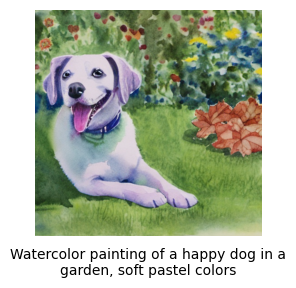

In [47]:

# Run generation with steering
prompt = [pos_batch[0]]
steered_images = generate_with_steering(
    pipe,
    prompt[0],
    steering_vectors,
    num_inference_steps=30,
    guidance_scale=7.5,
    lam=1.0,
    last_t=1,   # steer on last 5 steps
)
# Visualize
show_images(steered_images, prompt, cols=1)
